## Processing 1991-2010 weather & solar radiation data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import time 
import datetime
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from palettable.colorbrewer.sequential import OrRd_6
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import RdPu_5

In [110]:
# class 1 & 3 data
yearsites_temp = finalist[0]
yearsites_precip = finalist[1]
yearsites_solrad = finalist[2]

print('temp:', len(yearsites_temp))
print('precip:', len(yearsites_precip))
print('solrad:', len(yearsites_solrad))

yearsites = list(set(yearsites_temp) & set(yearsites_temp))
yearsites = list(set(yearsites) & set(yearsites_precip))
yearsites = list(set(yearsites) & set(yearsites_solrad))

yearsites.sort()

print('overlapping siteyears:', len(yearsites))

temp: 2340
precip: 1113
solrad: 12010
overlapping siteyears: 1014


In [117]:
# just with class1 data
yearsites_temp = finalist[0]
yearsites_precip = finalist[1]
yearsites_solrad = finalist[2]

print('temp:', len(yearsites_temp))
print('precip:', len(yearsites_precip))
print('solrad:', len(yearsites_solrad))

yearsites = list(set(yearsites_temp) & set(yearsites_temp))
yearsites = list(set(yearsites) & set(yearsites_precip))
yearsites = list(set(yearsites) & set(yearsites_solrad))

yearsites.sort()

print('overlapping siteyears:', len(yearsites))

temp: 1499
precip: 918
solrad: 4840
overlapping siteyears: 820


In [112]:
print(crithrs_1)
print(crithrs_3)

836
1014


In [ ]:
# what are the valid site-years?
years = list()
sites = list()

for i in range(len(yearsites)):
    year = yearsites[i][0:4]
    years.append(year)
    site = yearsites[i][5:11]
    sites.append(site)

df_yearsites = pd.DataFrame({'site': sites, 'year': years}, 
                            columns=['site', 'year'])
df_yearsites = df_yearsites.sort_values(['site', 'year'])
final_sites = list(set(df_yearsites.site))
#df_yearsites.to_csv('../weadata/site_year_crithr1_9110.csv')

### Compile and gap-fill usable site-years data into individual weather data files

In [20]:
# time zone finder
def find_zone(site):
    """
    find time zone for specific sites
    """
    lat = float(siteinfo[siteinfo.site == site].lat)
    lon = float(siteinfo[siteinfo.site == site].lon) * -1
    tf = TimezoneFinder()    
    zone = tf.timezone_at(lng=lon, lat=lat)
    return zone

In [21]:
# utc conversion to local time
def utc_to_local(times, zone):
    """
    convert list of utc timestamps into local time
    """
    times = times.to_pydatetime() # convert from pd.DatetimeIndex into python datetime format
    utc = pytz.timezone('UTC') # setting up the UTC timezone, requires package 'pytz'
    local_datetime = list()
    
    for time in times:
        utctime = utc.localize(time) # adding UTC timezone to datetime
        localtime = utctime.astimezone(pytz.timezone(zone)) 
        datetime = pd.to_datetime(localtime)
        local_datetime.append(datetime)
        
    return local_datetime

In [ ]:
%%time # code block run time ~52 mins

### setting up growing season period
#season_start, season_end = '04-01', '10-31'
season_start, season_end = '03-01', '11-30' # 200701: after looking at the USDA/NASS plant progress data,
                                            # I wanted to extend the growing season window broader for weather data selection

### reading in required files
siteinfo = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_info.csv', dtype='str', usecols=[1,2,3,4,5])
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr1.csv', dtype='str', usecols=[1,2])
siteyear = siteyear[siteyear.site != '41415'] # dropping out Guam within dataset

### starting the loop to process each site-year
for i in np.arange(siteyear.shape[0]): 
    # selecting site-year combinations
    site = siteyear.iloc[i,0]
    year = siteyear.iloc[i,1]
    print(site, year)
    
    # constructing dataframe that will hold all weather data
    col = ['jday','date','hour','solrad','temp','precip','rh', 'co2']
    df_wea = pd.DataFrame(columns=col)

    # setting up for time-relating entries
    times = pd.date_range(season_start + '-' + str(year), 
                          season_end + '-' + str(year)+ ' 23:00:00', freq='1H') # utc time
    zone = find_zone(site)
    local_datetime = utc_to_local(times, zone)
            
    # selecting weather data
    utc_start, utc_end = str(times[0]), str(times[-1])
    df_wea.temp = list(df_temp[utc_start:utc_end][site])
    df_wea.rh = list(np.round((df_rh[utc_start:utc_end][site])*100, 2))
    df_wea.precip = list(df_precip[utc_start:utc_end][site]/10) #*** this is a temporary fix for precip scaling bug
    df_wea.co2 = 400    

    # selecting solar radiation 
    t1 = pd.to_datetime(utc_start).to_pydatetime()
    t2 = pd.to_datetime(utc_end).to_pydatetime()
    tdiff = t2-t1
    local_start = str(local_datetime[0])[:19] 
    local_end = str(pd.to_datetime(local_start).to_pydatetime() + tdiff)[:19]
    df_wea.solrad = list(df_solrad[local_start:local_end][site])

    # adding time-relating info to data frame
    local = pd.date_range(local_start, local_end, freq='H')
    df_wea.jday = local.dayofyear
    df_wea.date = local.strftime("'%m/%d/%Y'")
    df_wea.hour = local.hour    
    
    # gap-filling weather data
    if df_wea.isna().sum().sum() > 0:
        # creating a log file that documents the number of missing data for each site-year
        f = open('/home/disk/eos8/ach315/upscale/weadata/data/log.txt', 'a+')
        f.write('site: %s' %siteyear.iloc[i,:][0])
        f.write(', year: %s' %siteyear.iloc[i,:][1])
        f.write(', gap-filled: %s\r\n' %df_wea.isna().sum().sum())
        f.close()
        
        # gap-filling data by linearly interpolating with data from hour before and after
        df_wea = df_wea.interpolate() 
        
    # saving individual site-year weather file into .csv 
#    df_wea.to_csv('/home/disk/eos8/ach315/upscale/weadata/data/control/' + site + '_' + year + '.txt', sep='\t', index=False)
    

### Create site list that merges WBAN & USAF coding
- Main input
    - /data/ISH_NSRD/NSRDB_StationsMeta.csv
    - /upsale/weadata/site_info.csv
    - /upscale/weadata/site_year_crithr1_9110.csv
    - /upscale/weadata/site_year_crithr1.csv
- Main output
    - df_sites_usaf
    - df_sties_wban
    - df_sites

#### Years 1961-1990

In [93]:
# read in spreadsheet linking WBAN & USAF station ID
df_ids = pd.read_csv('/home/disk/eos8/ach315/data/ISH_NSRD/stations_wban_usaf.csv', header=None, dtype='str')
df_ids.columns = ['WBAN', 'USAF']

# read in 1961-1990 sites
df_stations_6190 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_info.csv', 
                               index_col=0, dtype={'site': object})
# merge USAF site IDs
df_sites_6190 = df_stations_6190.merge(df_ids, left_on='site', right_on='WBAN')

# filtering only for sites with usable site-years
df_siteyears_6190 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr0.csv', 
                                index_col=0, dtype='str')
df_sites_6190 = df_sites_6190[df_sites_6190['WBAN'].isin(df_siteyears_6190.site)]
df_sites_6190.head()

,site,city,state,lat,lon,WBAN,USAF
1,03812,ASHEVILLE,NC,35.26,82.32,03812,723150
2,03813,MACON,GA,32.42,83.39,03813,722170
3,03820,AUGUSTA,GA,33.22,81.58,03820,722180
4,03822,SAVANNAH,GA,32.08,81.12,03822,722070
5,03856,HUNTSVILLE,AL,34.39,86.46,03856,723230


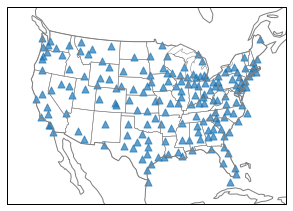

In [46]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(central_latitude=29.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_sites_6190['lon']*-1, df_sites_6190['lat'], 
           transform=ccrs.PlateCarree(), s=50, marker='^', alpha=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

#### Years 1991-2010

In [98]:
df_stations_9110 = pd.read_csv('/home/disk/eos8/ach315/data/ISH_NSRD/NSRDB_StationsMeta.csv')
df_siteyears_9110 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr1_9110.csv', index_col=0)
df_sites_9110 = df_stations_9110[df_stations_9110['USAF'].isin(df_siteyears_9110.site)]
df_sites_9110.head()

,USAF,CLASS,SOLAR,STATION,ST,NSRDB_LAT (dd),NSRDB_LON(dd),NSRDB_ELEV (m),TIME ZONE,ISH_LAT (dd),ISH_LON(dd),ISH_ELEV (m),20120619
127,722010,1,0,KEY WEST INTL ARPT,FL,24.550,-81.750,1,-5,24.550,-81.750,1,NaN
132,722020,1,0,MIAMI INTL AP,FL,25.817,-80.300,11,-5,25.817,-80.300,11,NaN
139,722030,1,0,WEST PALM BEACH INTL ARPT,FL,26.683,-80.100,6,-5,26.683,-80.100,6,NaN
147,722050,1,0,ORLANDO INTL ARPT,FL,28.433,-81.333,29,-5,28.433,-81.333,29,NaN
150,722056,1,0,DAYTONA BEACH INTL AP,FL,29.183,-81.067,9,-5,29.183,-81.067,9,NaN


In [96]:
df_sites_6190[df_sites_6190['USAF'] == '722010']

,site,city,state,lat,lon,WBAN,USAF
18,12836,KEY WEST,FL,24.33,81.45,12836,722010


In [101]:
df_sites_9110[df_sites_9110['USAF'] == 722010]

,USAF,CLASS,SOLAR,STATION,ST,NSRDB_LAT (dd),NSRDB_LON(dd),NSRDB_ELEV (m),TIME ZONE,ISH_LAT (dd),ISH_LON(dd),ISH_ELEV (m),20120619
127,722010,1,0,KEY WEST INTL ARPT,FL,24.55,-81.75,1,-5,24.55,-81.75,1,NaN


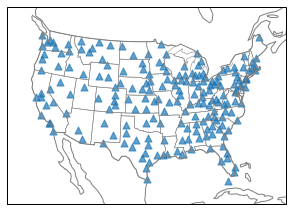

In [18]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(central_latitude=29.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_sites_9110['NSRDB_LON(dd)'], df_sites_9110['NSRDB_LAT (dd)'], 
           transform=ccrs.PlateCarree(), s=50, marker='^', alpha=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_featureb(cfeature.STATES, edgecolor='grey', linewidth=0.5)

In [48]:
df_sites_6190.USAF

1      723150
2      722170
3      722180
4      722070
5      723230
        ...  
232    725300
233    725370
234    726390
235    726350
236    725480
Name: USAF, Length: 198, dtype: object

In [56]:
df_sites_9110[df_sites_9110['USAF'].isin(df_sites_6190.USAF)].shape

(175, 13)

In [67]:
name = '/home/disk/eos8/ach315/data/ISH/2007/700634-27408-2007'

year = 2007
dateparse = lambda dates: [datetime.datetime.strptime(d, "%Y%m%d%H") for d in dates] # dateparsing method to be used in pd.read_fwf
season_start, season_end = '03-01-', '11-30-' # setting a pretty borad range for growing season
colnames = ['time', 'temp', 'dew_temp', 'precip', 'precip_time', 'precip_depth', 'precip_condition', 'precip_quality', 'rh']
colspecs = [(15,25), (87,92), (93,98), (105,8193)]

df = pd.read_fwf(name, names=colnames, colspecs=colspecs, header=None, index_col='time',
                 encoding='latin_1', dtype={'temp':int, 'precip':str}, 
                 parse_dates=True, date_parser=dateparse)
df.head()

,temp,dew_temp,precip,precip_time,precip_depth,precip_condition,precip_quality,rh
time,,,,,,,,
2007-01-01 00:00:00,-290,-320,ADDAU110030015AW1715GA1045+006715999GA2075+012...,NaN,NaN,NaN,NaN,NaN
2007-01-01 01:00:00,-300,-330,ADDGA1045+009145999GA2045+021345999GA3075+0274...,NaN,NaN,NaN,NaN,NaN
2007-01-01 02:00:00,-310,-340,ADDAU110030015AW1715GA1045+009145999GA2045+021...,NaN,NaN,NaN,NaN,NaN
2007-01-01 03:00:00,-310,-340,ADDGA1045+009145999GA2045+021345999GA3075+0274...,NaN,NaN,NaN,NaN,NaN
2007-01-01 12:00:00,-380,-410,ADDAU100001015AW1105GA1045+027435999GD12991+02...,NaN,NaN,NaN,NaN,NaN


In [68]:
name = '/home/disk/eos8/ach315/data/ISH/2007/700634-99999-2007'

year = 2007
dateparse = lambda dates: [datetime.datetime.strptime(d, "%Y%m%d%H") for d in dates] # dateparsing method to be used in pd.read_fwf
season_start, season_end = '03-01-', '11-30-' # setting a pretty borad range for growing season
colnames = ['time', 'temp', 'dew_temp', 'precip', 'precip_time', 'precip_depth', 'precip_condition', 'precip_quality', 'rh']
colspecs = [(15,25), (87,92), (93,98), (105,8193)]

df = pd.read_fwf(name, names=colnames, colspecs=colspecs, header=None, index_col='time',
                 encoding='latin_1', dtype={'temp':int, 'precip':str}, 
                 parse_dates=True, date_parser=dateparse)
df.head()

,temp,dew_temp,precip,precip_time,precip_depth,precip_condition,precip_quality,rh
time,,,,,,,,
2007-01-01 00:00:00,-290,-320,ADDGD12991+0066099GD23991+0126099GD33991+02100...,NaN,NaN,NaN,NaN,NaN
2007-01-01 01:00:00,-300,-330,ADDGD12991+0090099GD22991+0210099GD33991+02700...,NaN,NaN,NaN,NaN,NaN
2007-01-01 02:00:00,-310,-340,ADDGD12991+0090099GD22991+0210099GD33991+02700...,NaN,NaN,NaN,NaN,NaN
2007-01-01 03:00:00,-310,-340,ADDGD12991+0090099GD22991+0210099GD33991+02700...,NaN,NaN,NaN,NaN,NaN
2007-01-01 12:00:00,-380,-410,ADDGD12991+0270099GF104991999999999999999999MA...,NaN,NaN,NaN,NaN,NaN
